# TRAPpy custom events

Detailed information on Trappy can be found at **examples/trappy/trappy_example.ipynb**.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2016-12-12 12:37:47,136 INFO    : root         : Using LISA logging configuration:
2016-12-12 12:37:47,136 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
# Generate plots inline
%matplotlib inline

import copy
import json
import os
import time
import math
import logging

# Support to access the remote target
import devlib
from env import TestEnv

# Support to configure and run RTApp based workloads
from wlgen import RTA

# Support for performance analysis of RTApp workloads
from perf_analysis import PerfAnalysis

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

## Test environment setup

For more details on this please check out **examples/utils/testenv_example.ipynb**.

In [3]:
# Setup a target configuration
my_target_conf = {
    
    # Define the kind of target platform to use for the experiments
    "platform"    : 'linux',  # Linux system, valid other options are:
                              # android - access via ADB
                              # linux   - access via SSH
                              # host    - direct access
    
    # Preload settings for a specific target
    "board"       : 'juno',  # juno - JUNO board with mainline hwmon
    
    # Define devlib module to load
    "modules"     : [
        'bl',           # enable big.LITTLE support
        'cpufreq'       # enable CPUFreq support
    ],

    # Account to access the remote target
    "host"        : '192.168.0.1',
    "username"    : 'root',
    "password"    : 'juno',

    # Comment the following line to force rt-app calibration on your target
    "rtapp-calib" : {
        '0': 361, '1': 138, '2': 138, '3': 352, '4': 360, '5': 353
    }

}

# Setup the required Test Environment supports
my_tests_conf = {
        
    # Binary tools required to run this experiment
    # These tools must be present in the tools/ folder for the architecture
    "tools"   : ['trace-cmd'],
    
    # FTrace events buffer configuration
    # events listed here MUST be 
    "ftrace"  : {
        
        
##############################################################################
# EVENTS SPECIFICATIPON
##############################################################################
# Here is where we specify the list of events we are interested into:
# Events are of two types:
# 1. FTrace tracepoints that _must_ be supported by the target's kernel in use.
#    These events will be enabled at ftrace start time, thus if the kernel does
#    not support one of them, ftrace starting will fails.

        "events" : [
            "sched_switch",
            "cpu_frequency",
        ],

# 2. FTrace events generated via trace_printk, from either kernel or user
#    space. These events are different from the previous because they do not
#    need to be explicitely enabled at ftrace start time.
#    It's up to the user to ensure that the generated events satisfies these
#    formatting requirements:
#    a) the name must be a unique word into the trace
#    b) values must be reported as a sequence of key=value paires
#    For example, a valid custom event string is:
#      my_math_event: kay1=val1 key2=val2 key3=val3

        "custom" : [
            "my_math_event",
        ],
        
# For each of these events, TRAPpy will generate a Pandas dataframe accessible
# via a TRAPpy::FTrace object, whith the same name of the event.
# Thus for example, ftrace.my_math_event will be the object exposing the
# dataframe with all the event matching the "my_math_event" unique word.
        
##############################################################################
        
         "buffsize" : 10240,
    },

}

In [4]:
# Initialize a test environment using:
#  - the provided target configuration (my_target_conf)
#  - the provided test configuration (my_test_conf)
te = TestEnv(target_conf=my_target_conf, test_conf=my_tests_conf)
target = te.target

2016-12-12 12:37:50,978 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2016-12-12 12:37:50,980 INFO    : TestEnv      : Loading custom (inline) target configuration
2016-12-12 12:37:50,981 INFO    : TestEnv      : Loading custom (inline) test configuration
2016-12-12 12:37:50,982 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpufreq', 'hwmon']
2016-12-12 12:37:50,983 INFO    : TestEnv      : Connecting linux target:
2016-12-12 12:37:50,983 INFO    : TestEnv      :   username : root
2016-12-12 12:37:50,984 INFO    : TestEnv      :       host : 192.168.0.1
2016-12-12 12:37:50,984 INFO    : TestEnv      :   password : juno
2016-12-12 12:37:50,985 INFO    : TestEnv      : Connection settings:
2016-12-12 12:37:50,985 INFO    : TestEnv      :    {'username': 'root', 'host': '192.168.0.1', 'password': 'juno'}
2016-12-12 12:38:07,171 INFO    : TestEnv      : Initializing target workdir:
2016-12-12 12:38:07,171 INFO    : TestEnv      :    /root/devlib-target
2016-12-12 

In [5]:
logging.info("Target ABI: %s, CPus: %s",
             target.abi,
             target.cpuinfo.cpu_names)

2016-12-12 12:38:25,875 INFO    : root         : Target ABI: arm64, CPus: ['A53', 'A57', 'A57', 'A53', 'A53', 'A53']


## Example of custom event definition

In [6]:
# Define the format string for the custom events we will inject from user-space
my_math_event_fmt = "my_math_event: sin={} cos={}"

# Start FTrace
te.ftrace.start()

# Let's generate some interesting "custom" events from userspace
logging.info('Generating events from user-space (will take ~140[s])...')
for angle in range(360):
    v_sin = int(1e6 * math.sin(math.radians(angle)))
    v_cos = int(1e6 * math.cos(math.radians(angle)))
    my_math_event = my_math_event_fmt.format(v_sin, v_cos)
    # custom events can be generated either from userspace, like in this
    # example, or also from kernelspace (using a trace_printk call)
    target.execute('echo {} > /sys/kernel/debug/tracing/trace_marker'\
                   .format(my_math_event))

# Stop FTrace
te.ftrace.stop()

2016-12-12 12:38:33,871 INFO    : root         : Generating events from user-space (will take ~140[s])...


In [7]:
# Collect the generate trace
trace_file = '/tmp/trace.dat'
te.ftrace.get_trace(trace_file)

In [8]:
# Parse trace
events_to_parse = my_tests_conf['ftrace']['events'] + my_tests_conf['ftrace']['custom']
trace = Trace('/tmp', events_to_parse, te.platform)

2016-12-12 12:44:50,076 INFO    : Trace        : Parsing FTrace format...
2016-12-12 12:44:51,500 INFO    : Trace        : Platform clusters verified to be Frequency coherent
2016-12-12 12:44:51,682 INFO    : Trace        : Collected events spans a 113.228 [s] time interval
2016-12-12 12:44:51,682 INFO    : Trace        : Set plots time range to (0.000000, 113.227578)[s]
2016-12-12 12:44:51,683 INFO    : Analysis     : Registering trace analysis modules:
2016-12-12 12:44:51,684 INFO    : Analysis     :    tasks
2016-12-12 12:44:51,684 INFO    : Analysis     :    status
2016-12-12 12:44:51,687 INFO    : Analysis     :    frequency
2016-12-12 12:44:51,688 INFO    : Analysis     :    cpus
2016-12-12 12:44:51,690 INFO    : Analysis     :    latency
2016-12-12 12:44:51,693 INFO    : Analysis     :    idle
2016-12-12 12:44:51,694 INFO    : Analysis     :    functions
2016-12-12 12:44:51,695 INFO    : Analysis     :    eas


## Inspection of the generated TRAPpy FTrace object

In [9]:
# Get the TRAPpy FTrace object which has been generated from the trace parsing
ftrace = trace.ftrace

In [10]:
# The FTrace object allows to verify which (of the registered) events have been
# identified into the trace
logging.info("List of events identified in the trace:\n%s",
             ftrace.class_definitions.keys())

2016-12-12 12:44:55,642 INFO    : root         : List of events identified in the trace:
['cpu_frequency', 'my_math_event', 'sched_switch', 'cpu_idle']


In [11]:
# Each event identified in the trace is appended to a table (i.e. data_frame)
# which has the same name of the event
logging.info("First 10 events of our 'my_math_event' custom event:")
ftrace.my_math_event.data_frame.head(10)

2016-12-12 12:44:57,476 INFO    : root         : First 10 events of our 'my_math_event' custom event:


,__comm,__cpu,__pid,cos,sin
Time,,,,,
0.000000,bash,2,608,1000000,0
0.309391,bash,2,608,999847,17452
0.621478,bash,2,608,999390,34899
0.932506,bash,1,608,998629,52335
1.242157,bash,2,608,997564,69756
1.551930,bash,1,608,996194,87155
1.863359,bash,2,608,994521,104528
2.173332,bash,1,608,992546,121869
2.484736,bash,2,608,990268,139173


In [12]:
logging.info("First 10 events of our 'cpu_frequency' tracepoint:")
ftrace.cpu_frequency.data_frame.head(10)

2016-12-12 12:44:58,945 INFO    : root         : First 10 events of our 'cpu_frequency' tracepoint:


,__comm,__cpu,__pid,cpu,frequency
Time,,,,,
111.728239,cfinteractive,2,44,1,625000
111.728245,cfinteractive,2,44,2,625000
111.868680,cfinteractive,2,44,1,450000
111.868690,cfinteractive,2,44,2,450000


## Plotting tracepoint and/or custom events

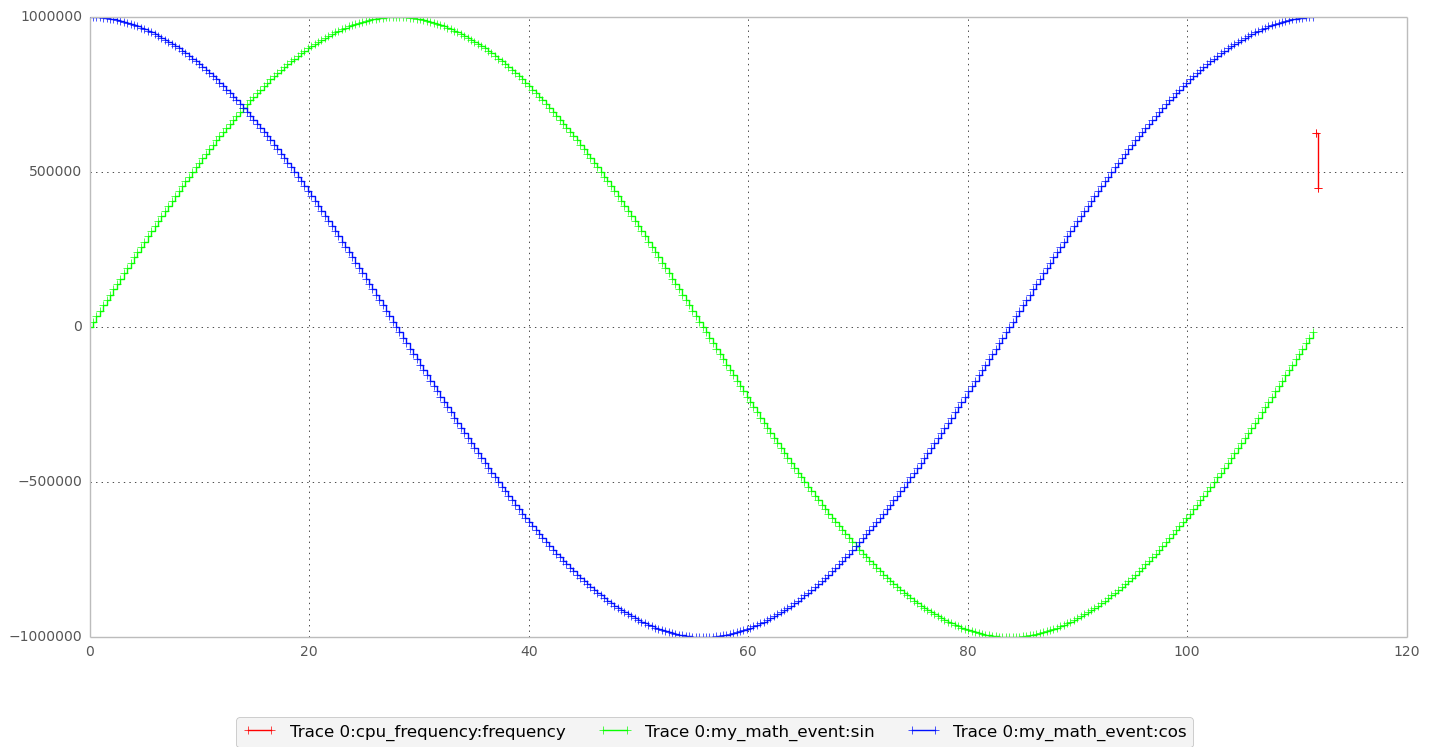

In [13]:
# It is possible to mix in the same plot tracepoints and custom events

# The LinePlot module requires to specify a list of signals to plot.
# Each signal is defined as:
#       <event>:<column>
# where:
#  <event>   is one of the events collected from the trace by the FTrace object
#  <column>  is one of the column of the previously defined event
my_signals = [
    'cpu_frequency:frequency',
    'my_math_event:sin',
    'my_math_event:cos'
]

# These two paramatere are passed to the LinePlot call as long with the
# TRAPpy FTrace object
trappy.LinePlot(
    ftrace,                      # FTrace object
    signals=my_signals,          # Signals to be plotted
    drawstyle='steps-post',      # Plot style options
    marker = '+'
).view()